In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

1. Import the dataset

In [39]:
df_train = pd.read_csv(r"C:\Data_for_learning_overall\MCI_test\ChurnRate\churn-bigml-80.csv")
df_test = pd.read_csv(r"C:\Data_for_learning_overall\MCI_test\ChurnRate\churn-bigml-20.csv")

In [40]:
df_train

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


2. EDA

- Printing out all the Boxplot 

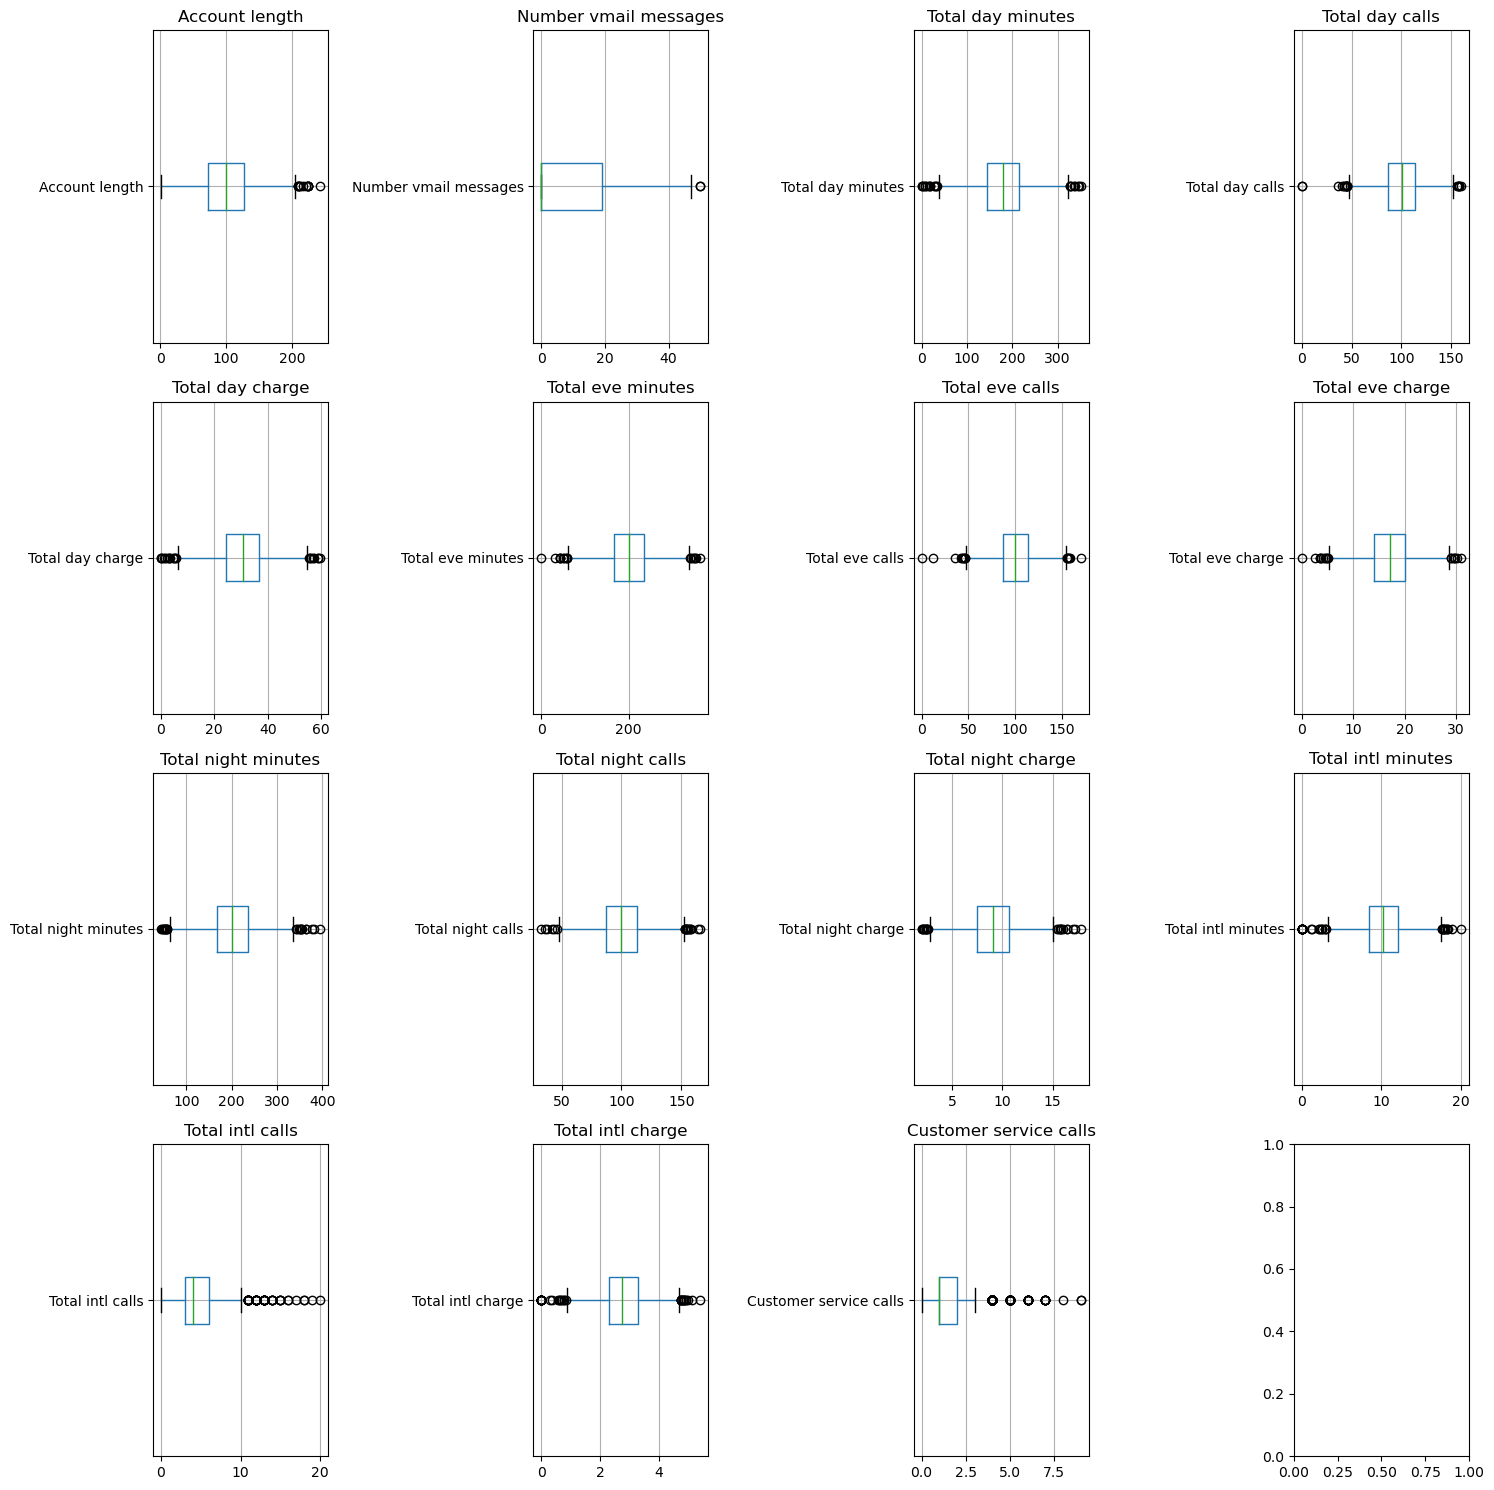

In [41]:
columns_for_boxplots = [
    'Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls',
    'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge',
    'Total night minutes', 'Total night calls', 'Total night charge',
    'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls'
]

# Creating subplots for boxplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Plotting boxplots for each selected column
for i, column in enumerate(columns_for_boxplots):
    df_train.boxplot(column=column, ax=axes[i], vert=False)
    axes[i].set_title(column)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

- Remove datapoint which are potential outliers because they are far from the mean point by Z-Score 

In [42]:

# Specify the columns for which you want to remove outliers
columns_for_outliers = [
    'Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls',
    'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge',
    'Total night minutes', 'Total night calls', 'Total night charge',
    'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls'
]

# Calculate Z-scores for specified columns
z_scores = np.abs(stats.zscore(df_train[columns_for_outliers]))

# Define a threshold (e.g., 3) for Z-score beyond which data points are considered outliers
threshold = 3

# Create a mask for outliers
outlier_mask = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
df_train_no_outliers = df_train[~outlier_mask]

# Print the shape of the original and outlier-removed DataFrames
print("Original DataFrame shape:", df_train.shape)
print("DataFrame shape after removing outliers:", df_train_no_outliers.shape)


Original DataFrame shape: (2666, 20)
DataFrame shape after removing outliers: (2536, 20)


In [43]:
churn_counts = df_train['Churn'].value_counts()

print("Churn Value Counts:")
print(churn_counts)

Churn Value Counts:
Churn
False    2278
True      388
Name: count, dtype: int64


=> seems to be an unbalanced dataset this too many False values compare to True in Churn. Dealing with an imbalanced dataset, resampling with replacement, also known as oversampling, is one of the common techniques to avoid get a unbiased train/test dataset.

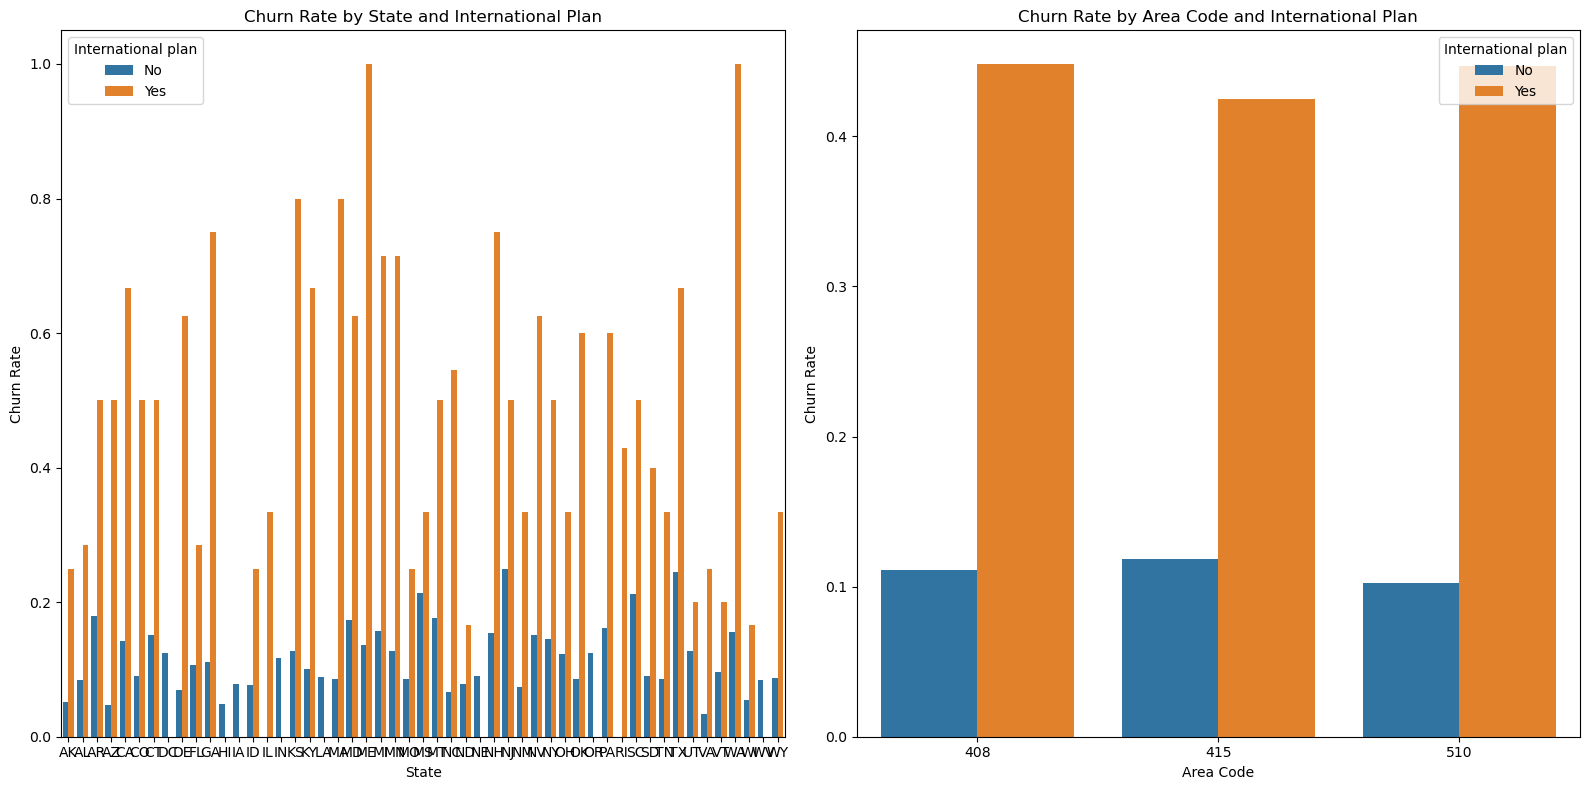

In [44]:
import matplotlib.pyplot as plt

# Aggregating data based on 'State' and 'International plan', and calculating Churn rates
agg_data_state = df_train.groupby(['State', 'International plan'])['Churn'].mean().reset_index()

# Aggregating data based on 'Area code' and 'International plan', and calculating Churn rates
agg_data_area = df_train.groupby(['Area code', 'International plan'])['Churn'].mean().reset_index()

# Plotting bar charts
plt.figure(figsize=(16, 8))

# Bar chart for 'State' and 'International plan'
plt.subplot(1, 2, 1)
sns.barplot(x='State', y='Churn', hue='International plan', data=agg_data_state)
plt.title('Churn Rate by State and International Plan')
plt.xlabel('State')
plt.ylabel('Churn Rate')

# Bar chart for 'Area code' and 'International plan'
plt.subplot(1, 2, 2)
sns.barplot(x='Area code', y='Churn', hue='International plan', data=agg_data_area)
plt.title('Churn Rate by Area Code and International Plan')
plt.xlabel('Area Code')
plt.ylabel('Churn Rate')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


- The churn rate seems to be different in every State but not nearly stay the same for all 3 Area. 

3. Data Processing 

- One hot Encoding for State and Area Code


In [45]:
# Assuming df_train is your original DataFrame
df_train_encoded = pd.get_dummies(df_train, columns=['State','Area code','International plan' ,'Voice mail plan'], drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=['State','Area code','International plan' ,'Voice mail plan'], drop_first=True)

- Split df_test and df_train to X_train,y_train , X_test and y_test

In [46]:
# Create X_train and y_train
X_train = df_train_encoded.drop('Churn', axis=1)
y_train = df_train_encoded['Churn']

# Create X_test and y_test
X_test = df_test_encoded.drop('Churn', axis=1)
y_test = df_test_encoded['Churn']

- Apply Standard Scaler to other columns 

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Applying models 

- Apply default models, I decided to use Random Forest, SVM, RandomForest and Decision Tree first.

In [48]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled,y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled,y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train_scaled,y_train)
svm_predictions = svm_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled,y_train)
dt_predictions = dt_model.predict(X_test_scaled)

- Models accuracy 

In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate models on the test set
models = [
    ('Logistic Regression', lr_model, X_test_scaled),
    ('Random Forest', rf_model, X_test_scaled),
    ('Support Vector Machine', svm_model, X_test_scaled),
    ('Decision Tree', dt_model, X_test_scaled)
]

for model_name, model, X_test_data in models:
    predictions = model.predict(X_test_data)
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")

Model: Logistic Regression
Accuracy: 0.8591
Model: Random Forest
Accuracy: 0.9400
Model: Support Vector Machine
Accuracy: 0.8696
Model: Decision Tree
Accuracy: 0.9310


In the first try, We managed to get really high accuracy score.This might be because of the well-structured the data

Random Forest and Decision tree leads in the Accuracy score between 4 models 

5. Improving the models 

Let's try to use gridsearch() for random forest and decision tree.

In [50]:
# Define model parameters
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200 ,250],
            'max_depth': [None, 10, 20, 30],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}


In [51]:
# Loop through the models and perform GridSearchCV
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_scaled, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Display the results
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [52]:
# Set the display option to show the entire content of 'best_params' column
pd.set_option('display.max_colwidth', None)

# Display the results
print(df)

           model  best_score  \
0  Random Forest    0.938485   
1  Decision Tree    0.932859   

                                                                                 best_params  
0                                                   {'max_depth': None, 'n_estimators': 100}  
1  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}  


- Try the best params for Decision Tree and Random Forest : 

In [53]:
# Best parameters from the grid search
best_params_rf = { 'max_depth': 20, 'n_estimators': 200}
best_params_dt = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

# Random Forest
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeClassifier(**best_params_dt)
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)

# Evaluate models on the test set
models = [
    ('Random Forest', rf_model, rf_predictions),
    ('Decision Tree', dt_model, dt_predictions)
]

for model_name, model, predictions in models:
    accuracy = accuracy_score(y_test, predictions)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")

Model: Random Forest
Accuracy: 0.9400
Model: Decision Tree
Accuracy: 0.9490


So, by using GridSearchCV(), I have improved the Decision Tree model alot from under 0.93 to around 0.94 to abover 0.95. Meanwhile the RandomForest model seems not to improved too much.

- Try using Bragging + decision Tree (Ensemble Learning)

In [61]:
from sklearn.ensemble import BaggingClassifier

# Specify parameters for the Bagging model
bagging_params = {
    'base_estimator': dt_model
}

# Instantiate BaggingClassifier with Decision Tree as the base estimator and specified parameters
bagging_model = BaggingClassifier(**bagging_params)

# Train the Bagging model
bagging_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
bagging_predictions = bagging_model.predict(X_test_scaled)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)

print("Model: Bagging with Decision Tree as Base Estimator")
print(f"Accuracy: {bagging_accuracy:.4f}")


C:\Users\vanhu\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: Bagging with Decision Tree as Base Estimator
Accuracy: 0.9610


Using Ensemble Learning + Decision Tree give a solid accuracy which is 0.9610 and this is the highest accuracy so far. 
In this dataset, I will choose Bagging model with decision tree({'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}) as base model 